# Torch optimizations
> Exploring how sample size (and other things, maybe) affects accuracy of our inference

In [1]:
import sys
sys.path.append('/home/phil/aptr')
%load_ext autoreload
%autoreload 2

In [10]:
from src.simulation import simulate_from_ids
from src.torch_solver import TorchSolver, solve_table
from src.database import RnaDB

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Initializations of a,b:

In [74]:
# # This takes ~30 minutes to run
# # This shows a distubing trend: model gets worse with larger sample sizes. Why?

# genomes = np.random.choice(RnaDB().genomes, size=10, replace=False)
# fig, axs = plt.subplots(3, 2, figsize=(10, 15))

# for i, scale in enumerate([1e4, 1e5, 1e6]):
#     # Simulate
#     _, coverages, ptrs, otu_matrix = simulate_from_ids(ids=genomes, scale=scale)
#     # Solve
#     solutions = solve_table(otu_matrix, genomes)
#     # Plot
#     for a,b,solution in zip(coverages, ptrs, solutions):
#         a_hat, b_hat, _ = solution
#         axs[i,0].scatter(a, np.exp(a_hat), color="k")
#         axs[i,0].set_title(scale)
#         axs[i,1].scatter(b, np.exp(b_hat), color="k")
#         axs[i,1].set_title(scale)


In [100]:
# Something is wrong here. Let's see if changing the initial guesses is useful.
# This takes ~2 minutes to run

# Filter to only complete genomes:
genomes = np.random.choice(RnaDB().complete_genomes, size=20, replace=False)

# Only need 1 sample for now
_, ptrs, abundances, otu_matrix = simulate_from_ids(
    ids=genomes, scale=1e7, n_samples=1
)

Simulating sample 1/1:
	Genome 1/20:	129338.5
	Genome 2/20:	1081646.3
	Genome 3/20:	760011.3
	Genome 4/20:	1051632.5
	Genome 5/20:	367928.6
	Genome 6/20:	383372.6
	Genome 7/20:	477641.3
	Genome 8/20:	479435.6
	Genome 9/20:	643561.4
	Genome 10/20:	499177.3
	Genome 11/20:	953739.5
	Genome 12/20:	867900.3
	Genome 13/20:	290402.41
	Genome 14/20:	1076550.3
	Genome 15/20:	525897.5
	Genome 16/20:	713604.4
	Genome 17/20:	358681.3
	Genome 18/20:	2113.3
	Genome 19/20:	340099.6
	Genome 20/20:	435591.13


Epoch 0:	 16.794960021972656
Epoch 1:	 10.421080589294434
Epoch 2:	 6.8795857429504395
Epoch 3:	 4.754753589630127
Epoch 4:	 3.3333771228790283
Epoch 5:	 2.3563716411590576
Epoch 6:	 1.668833613395691
Epoch 7:	 1.1829146146774292
Epoch 8:	 0.8386858105659485
Epoch 9:	 0.594542384147644
Epoch 10:	 0.42130520939826965
Epoch 11:	 0.2983758747577667
Epoch 12:	 0.2111605703830719
Epoch 13:	 0.14930492639541626
Epoch 14:	 0.10546065121889114
Epoch 15:	 0.07440212368965149
Epoch 16:	 0.05242285504937172
Epoch 17:	 0.03687944635748863
Epoch 18:	 0.02590075694024563
Epoch 19:	 0.018157148733735085
Epoch 20:	 0.012704309076070786
Epoch 21:	 0.008871213532984257
Epoch 22:	 0.006182126700878143
Epoch 23:	 0.004298745188862085
Epoch 24:	 0.002981828060001135
Epoch 25:	 0.0020625500474125147
Epoch 26:	 0.0014224797487258911
Epoch 27:	 0.000978016178123653
Epoch 28:	 0.0006702085374854505
Epoch 29:	 0.0004575235943775624
Epoch 30:	 0.00031091211712919176
Epoch 31:	 0.0002102651196764782
Epoch 32:	 0.

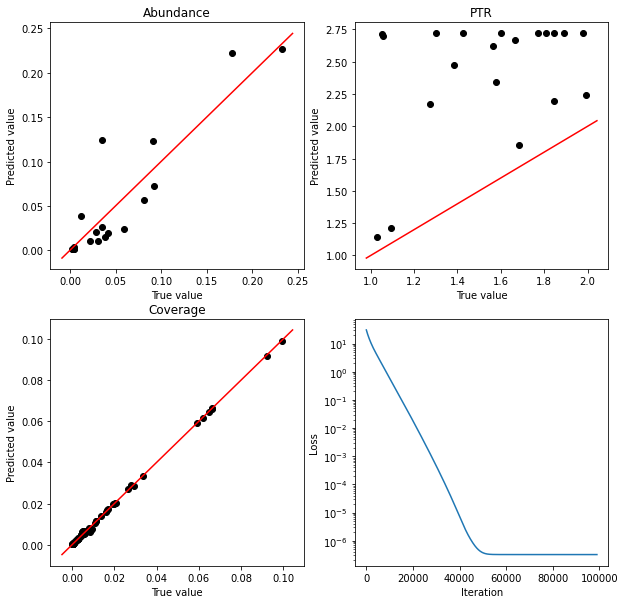

In [122]:
# Let's optimize just one sample, for speed
# First, let's see what we get with a regular system:

def init_experiment(a_hat, b_hat, **kwargs):
    solver = TorchSolver(
        genomes=RnaDB().generate_genome_objects(genomes)[0],
        coverages=otu_matrix[0],
    )

    a, b, loss = solver.train(
        epsilon=1e-10, tolerance=20, a_hat=a_hat, b_hat=b_hat, **kwargs
    )

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    plot_vals(abundances[:,0], np.exp(a), "Abundance", axs[0, 0])
    plot_vals(ptrs[:,0], np.exp(b), "PTR", axs[0, 1], normalize=False)

    # Note that otu_matrix is a DataFrame, so it is column-major.
    # Hence different indexing here (x[0] vs x[:,0])
    plot_vals(
        otu_matrix[0], 
        solver(solver.a_hat, solver.b_hat).detach().numpy(), 
        "Coverage", 
        axs[1, 0]
    )
    axs[1,1].plot(loss)
    axs[1,1].set_xlabel("Iteration")
    axs[1,1].set_ylabel("Loss")
    axs[1,1].set_yscale("log")

    return a, b, loss, solver

def plot_vals(x, y, title, ax, normalize=True):

    if normalize:
        x = x / np.sum(x)
        y = y / np.sum(y)
    ax.scatter(x, y, color="k", label="Prediction")
    ax.set_title(title)
    ax.set_xlabel("True value")
    ax.set_ylabel("Predicted value")
    ax.plot(
        ax.get_xlim(),
        ax.get_xlim(),
        color="r",
        label="y=x",
    )


random_init_results = init_experiment(a_hat=None, b_hat=None)


Epoch 0:	 6.070716381072998
Epoch 1:	 3.7185983657836914
Epoch 2:	 2.4169466495513916
Epoch 3:	 1.621002197265625
Epoch 4:	 1.105937123298645
Epoch 5:	 0.782965898513794
Epoch 6:	 0.5580034852027893
Epoch 7:	 0.3963336646556854
Epoch 8:	 0.28088468313217163
Epoch 9:	 0.19873619079589844
Epoch 10:	 0.14040471613407135
Epoch 11:	 0.09904814511537552
Epoch 12:	 0.06976529955863953
Epoch 13:	 0.049055133014917374
Epoch 14:	 0.034426718950271606
Epoch 15:	 0.024108024314045906
Epoch 16:	 0.016842542216181755
Epoch 17:	 0.011737191118299961
Epoch 18:	 0.008157969452440739
Epoch 19:	 0.005655547603964806
Epoch 20:	 0.003911472391337156
Epoch 21:	 0.0026997351087629795
Epoch 22:	 0.0018597985617816448
Epoch 23:	 0.001278562005609274
Epoch 24:	 0.0008769806590862572
Epoch 25:	 0.00060031603788957
Epoch 26:	 0.0004100894439034164
Epoch 27:	 0.00027939025312662125
Epoch 28:	 0.00018964380433317274
Epoch 29:	 0.0001281598670175299
Epoch 30:	 8.617442654212937e-05
Epoch 31:	 5.76462916797027e-05
Ep

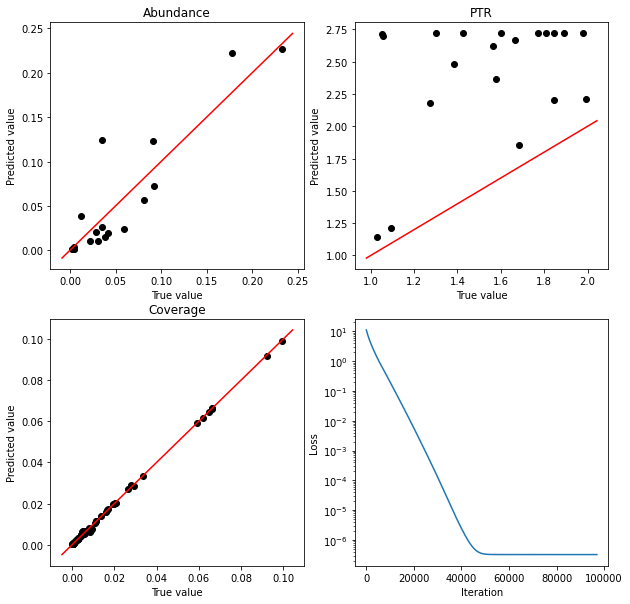

In [116]:
# If you init to zeros:

zero_init_results = init_experiment(
    a_hat=np.zeros(len(genomes)), b_hat=np.zeros(len(genomes))
)


Epoch 0:	 35.78529357910156
Epoch 1:	 22.987850189208984
Epoch 2:	 15.468701362609863
Epoch 3:	 10.671975135803223
Epoch 4:	 7.4631123542785645
Epoch 5:	 5.257284641265869
Epoch 6:	 3.717604637145996
Epoch 7:	 2.6338419914245605
Epoch 8:	 1.8675651550292969
Epoch 9:	 1.3245137929916382
Epoch 10:	 0.9392391443252563
Epoch 11:	 0.6657839417457581
Epoch 12:	 0.4716748893260956
Epoch 13:	 0.33393311500549316
Epoch 14:	 0.23621124029159546
Epoch 15:	 0.1669146567583084
Epoch 16:	 0.11780629307031631
Epoch 17:	 0.08303409069776535
Epoch 18:	 0.05843411386013031
Epoch 19:	 0.04104793444275856
Epoch 20:	 0.028777388855814934
Epoch 21:	 0.020129233598709106
Epoch 22:	 0.01404584664851427
Epoch 23:	 0.009775850921869278
Epoch 24:	 0.006786109413951635
Epoch 25:	 0.004698793403804302
Epoch 26:	 0.003246304579079151
Epoch 27:	 0.0022382033057510853
Epoch 28:	 0.0015398579416796565
Epoch 29:	 0.0010567271383479238
Epoch 30:	 0.0007233682554215193
Epoch 31:	 0.000494126055855304
Epoch 32:	 0.0003367

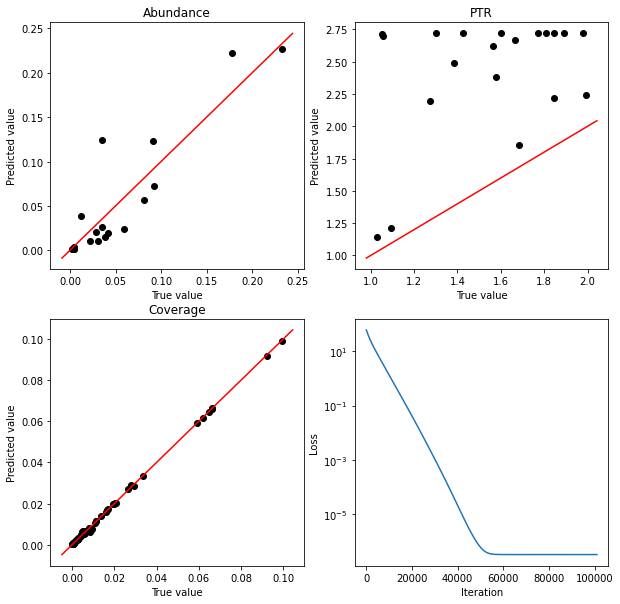

In [115]:
# If you init to ones:

ones_results = init_experiment(
    a_hat=np.ones(len(genomes)), b_hat=np.ones(len(genomes))
)


Epoch 0:	 5.346592903137207
Epoch 1:	 3.2865684032440186
Epoch 2:	 2.1683661937713623
Epoch 3:	 1.510271430015564
Epoch 4:	 1.0597676038742065
Epoch 5:	 0.7468702793121338
Epoch 6:	 0.5275054574012756
Epoch 7:	 0.37288254499435425
Epoch 8:	 0.2635844945907593
Epoch 9:	 0.1862258017063141
Epoch 10:	 0.1314520686864853
Epoch 11:	 0.09267587959766388
Epoch 12:	 0.06524648517370224
Epoch 13:	 0.0458599217236042
Epoch 14:	 0.03217155486345291
Epoch 15:	 0.022519560530781746
Epoch 16:	 0.015725983306765556
Epoch 17:	 0.01095412578433752
Epoch 18:	 0.007610349450260401
Epoch 19:	 0.0052736299112439156
Epoch 20:	 0.0036460270639508963
Epoch 21:	 0.002515599364414811
Epoch 22:	 0.001732207485474646
Epoch 23:	 0.001190075883641839
Epoch 24:	 0.0008156175026670098
Epoch 25:	 0.0005578337586484849
Epoch 26:	 0.0003806750464718789
Epoch 27:	 0.00025902906781993806
Epoch 28:	 0.00017557104001753032
Epoch 29:	 0.00011844807886518538
Epoch 30:	 7.950748113216832e-05
Epoch 31:	 5.3094645409146324e-05
E

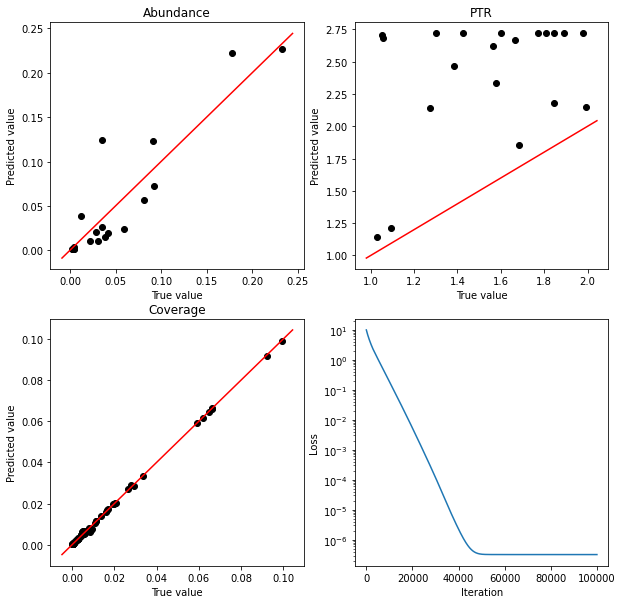

In [117]:
# log 1.5?

log1_5_results = init_experiment(
    a_hat=np.zeros(len(genomes)), b_hat=np.log(1.5 + np.zeros(len(genomes)))
)


Epoch 0:	 1.4121308595349547e-05
Epoch 1:	 5.437999789137393e-06
Epoch 2:	 1.968939841390238e-06
Epoch 3:	 7.761885854051798e-07
Epoch 4:	 5.129740543452499e-07
Epoch 5:	 4.2557121560093947e-07
Epoch 6:	 3.8399412005674094e-07
Epoch 7:	 3.593827102577052e-07
Epoch 8:	 3.536841006734903e-07
Epoch 9:	 3.476887400211126e-07
Epoch 10:	 3.413736635593523e-07
Epoch 11:	 3.351198643031239e-07
Epoch 12:	 3.2936853244791564e-07
Epoch 13:	 3.2443242048429966e-07
Epoch 14:	 3.233353709219955e-07
Epoch 15:	 3.2331161037291167e-07
Epoch 16:	 3.232953815768269e-07
Epoch 17:	 3.2328384236279817e-07
Epoch 18:	 3.2327503163287474e-07
Epoch 19:	 3.232680967357737e-07
Epoch 20:	 3.232621850202122e-07
Epoch 21:	 3.2325706911251473e-07
Epoch 22:	 3.232523511087493e-07
Epoch 23:	 3.232482583825913e-07
Epoch 24:	 3.232442509215616e-07
Epoch 25:	 3.2324035714736965e-07
Epoch 26:	 3.232365770600154e-07
Epoch 27:	 3.2323308118975547e-07
Epoch 28:	 3.232297274280427e-07
Epoch 29:	 3.2322643050974875e-07
Epoch 30

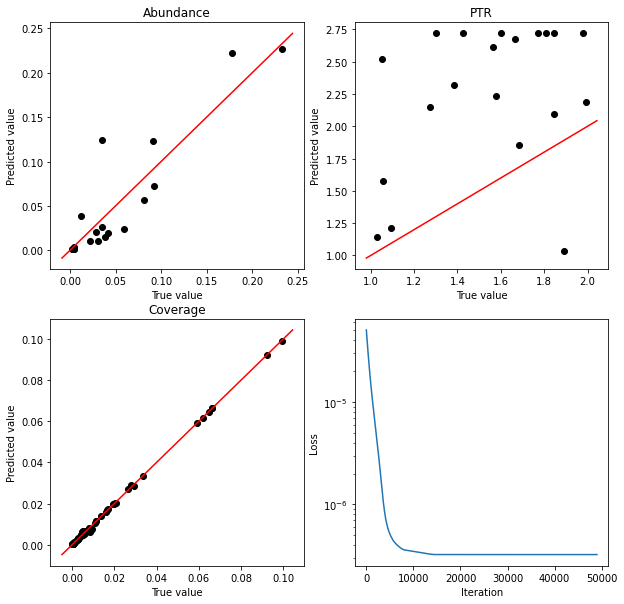

In [182]:
# What if we init to the true values?

correct_value_results = init_experiment(
    a_hat=np.log(abundances[:, 0] / np.sum(abundances[:, 0])), 
    b_hat=np.log(ptrs[:, 0])
)



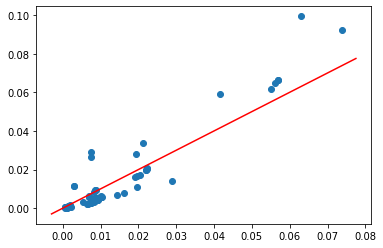

In [181]:
# OK, something is weird here. Let's try to run it forward:

true_a = np.log(abundances[:, 0] / np.sum(abundances[:, 0]))
true_b = np.log(ptrs[:, 0])

correct_solver = TorchSolver(
    genomes=RnaDB().generate_genome_objects(genomes)[0],
    coverages=otu_matrix[0] / np.sum(otu_matrix[0]),
)
predicted_coverages = correct_solver(
    torch.tensor(true_a, dtype=torch.float32), 
    torch.tensor(true_b, dtype=torch.float32)
).detach().numpy()

plt.scatter(
    predicted_coverages / np.sum(predicted_coverages),
    otu_matrix[0] / np.sum(otu_matrix[0])
)
plt.plot(plt.xlim(), plt.xlim(), color="r")

Epoch 0:	 5.062996569904499e-05


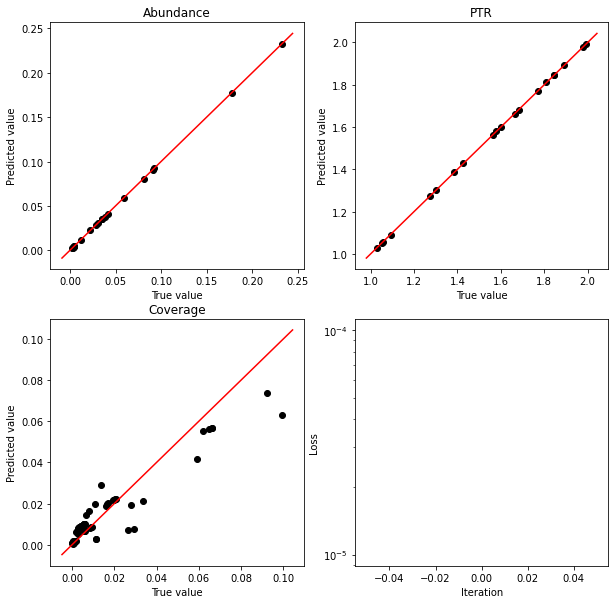

In [184]:
# Here's what it looks like when we don't overfit

correct_value_instant_results = init_experiment(
    a_hat=np.log(abundances[:, 0] / np.sum(abundances[:, 0])), 
    b_hat=np.log(ptrs[:, 0]),
    epochs=1,
    iterations=1
)



# Loss functions:
Let's start by just not overfitting the true values...